In [1]:
#@title **Libraries and Global Random Seeds**
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from pprint import pprint
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import optuna
from optuna.samplers import TPESampler

# ------------------------Controlling sources of randomness for reproducibility -----------------------
# however it was observed in the PyTorch documentation that randomness is not always guaranteed
seed = 42
torch.manual_seed(seed)
import random
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True  # if using GPU
torch.backends.cudnn.benchmark = False  # if using GPU, set this to False to ensure reproducibility

In [2]:
data_root=r'E:/Homework/Research/bridge model/Truss_v3/Truss_v3/'
project_root = 'E:/Homework/FYP/'
health_path = project_root + 'Health_Truss_data_v3'
damage_path = project_root + 'Damage_Truss_data_v3'

In [3]:
for i in range(1, 33):
    if i in [2, 3, 20, 29, 32]:
        continue
    filename = f'Health_Truss_v3/Health_Truss_data_v3/Health_Loadv{i}.csv'
    source_file = os.path.join(data_root,filename)
    shutil.copy(source_file, health_path)


In [4]:
for i in range(1, 35):
    if i in [4, 10, 16, 25, 26, 32, 34]:
        continue
    filename = f'Damage_Truss_v3\Damage_Truss_data_v3/Damage_Loadv{i}.csv'
    source_file = os.path.join(data_root,filename)
    shutil.copy(source_file, damage_path)

In [5]:
node_mapping = {
    1: 18, 2: 17, 3: 1, 5: 5, 6: 4, 7: 16, 8: 6, 9: 15,
    11: 19, 12: 9, 13: 8, 14: 10, 15: 7, 17: 21, 
    18: 11, 19: 14, 20: 12, 21: 22, 22: 23, 23: 13, 24: 24,
    27: 28, 28: 30, 29: 26, 30: 31, 31: 25, 33: 27
}

source_folder = 'E:/Homework/FYP/Damage_Truss_data_v3/'

files_in_directory = os.listdir(source_folder)
for file_name in files_in_directory:
    if file_name.endswith('.csv'):
        base_name = file_name.replace('.csv', '')
        number_part = int(base_name.split('v')[-1]) 
        if number_part in node_mapping:
            new_number = node_mapping[number_part]
            new_file_name = f'Damage_Load{new_number}.csv'
            old_file_path = os.path.join(source_folder, file_name)
            new_file_path = os.path.join(source_folder, new_file_name)
            os.rename(old_file_path, new_file_path)

In [6]:
node_mapping = {
    1: 18, 2: 17, 3: 1, 5: 5, 6: 4, 7: 16, 8: 6, 9: 15,
    11: 19, 12: 9, 13: 8, 14: 10, 15: 7, 17: 21, 
    18: 11, 19: 14, 20: 12, 21: 22, 22: 23, 23: 13, 24: 24,
    27: 28, 28: 30, 29: 26, 30: 31, 31: 25, 33: 27
}

# 循环遍历32个文件
for i in range(1, 33):    
    if i in [2, 3, 20, 29, 32]:
        continue
    filename = f'Damage_Load{i}.csv'
    file_path = os.path.join(damage_path, filename)
    df = pd.read_csv(file_path)
    df = df[~df['Node ID'].isin([4,10,16, 25, 26,32,34])]
    df['Node ID'] = df['Node ID'].replace(node_mapping)
    df.to_csv(file_path, index=False)
for i in range(1, 33):    
    if i in [2, 3, 20, 29, 32]:
        continue
    filename = f'Health_Loadv{i}.csv'
    file_path = os.path.join(health_path, filename)
    df = pd.read_csv(file_path)
    df = df[~df['Node ID'].isin([2,3,20,29,32])]
    df.to_csv(file_path, index=False)



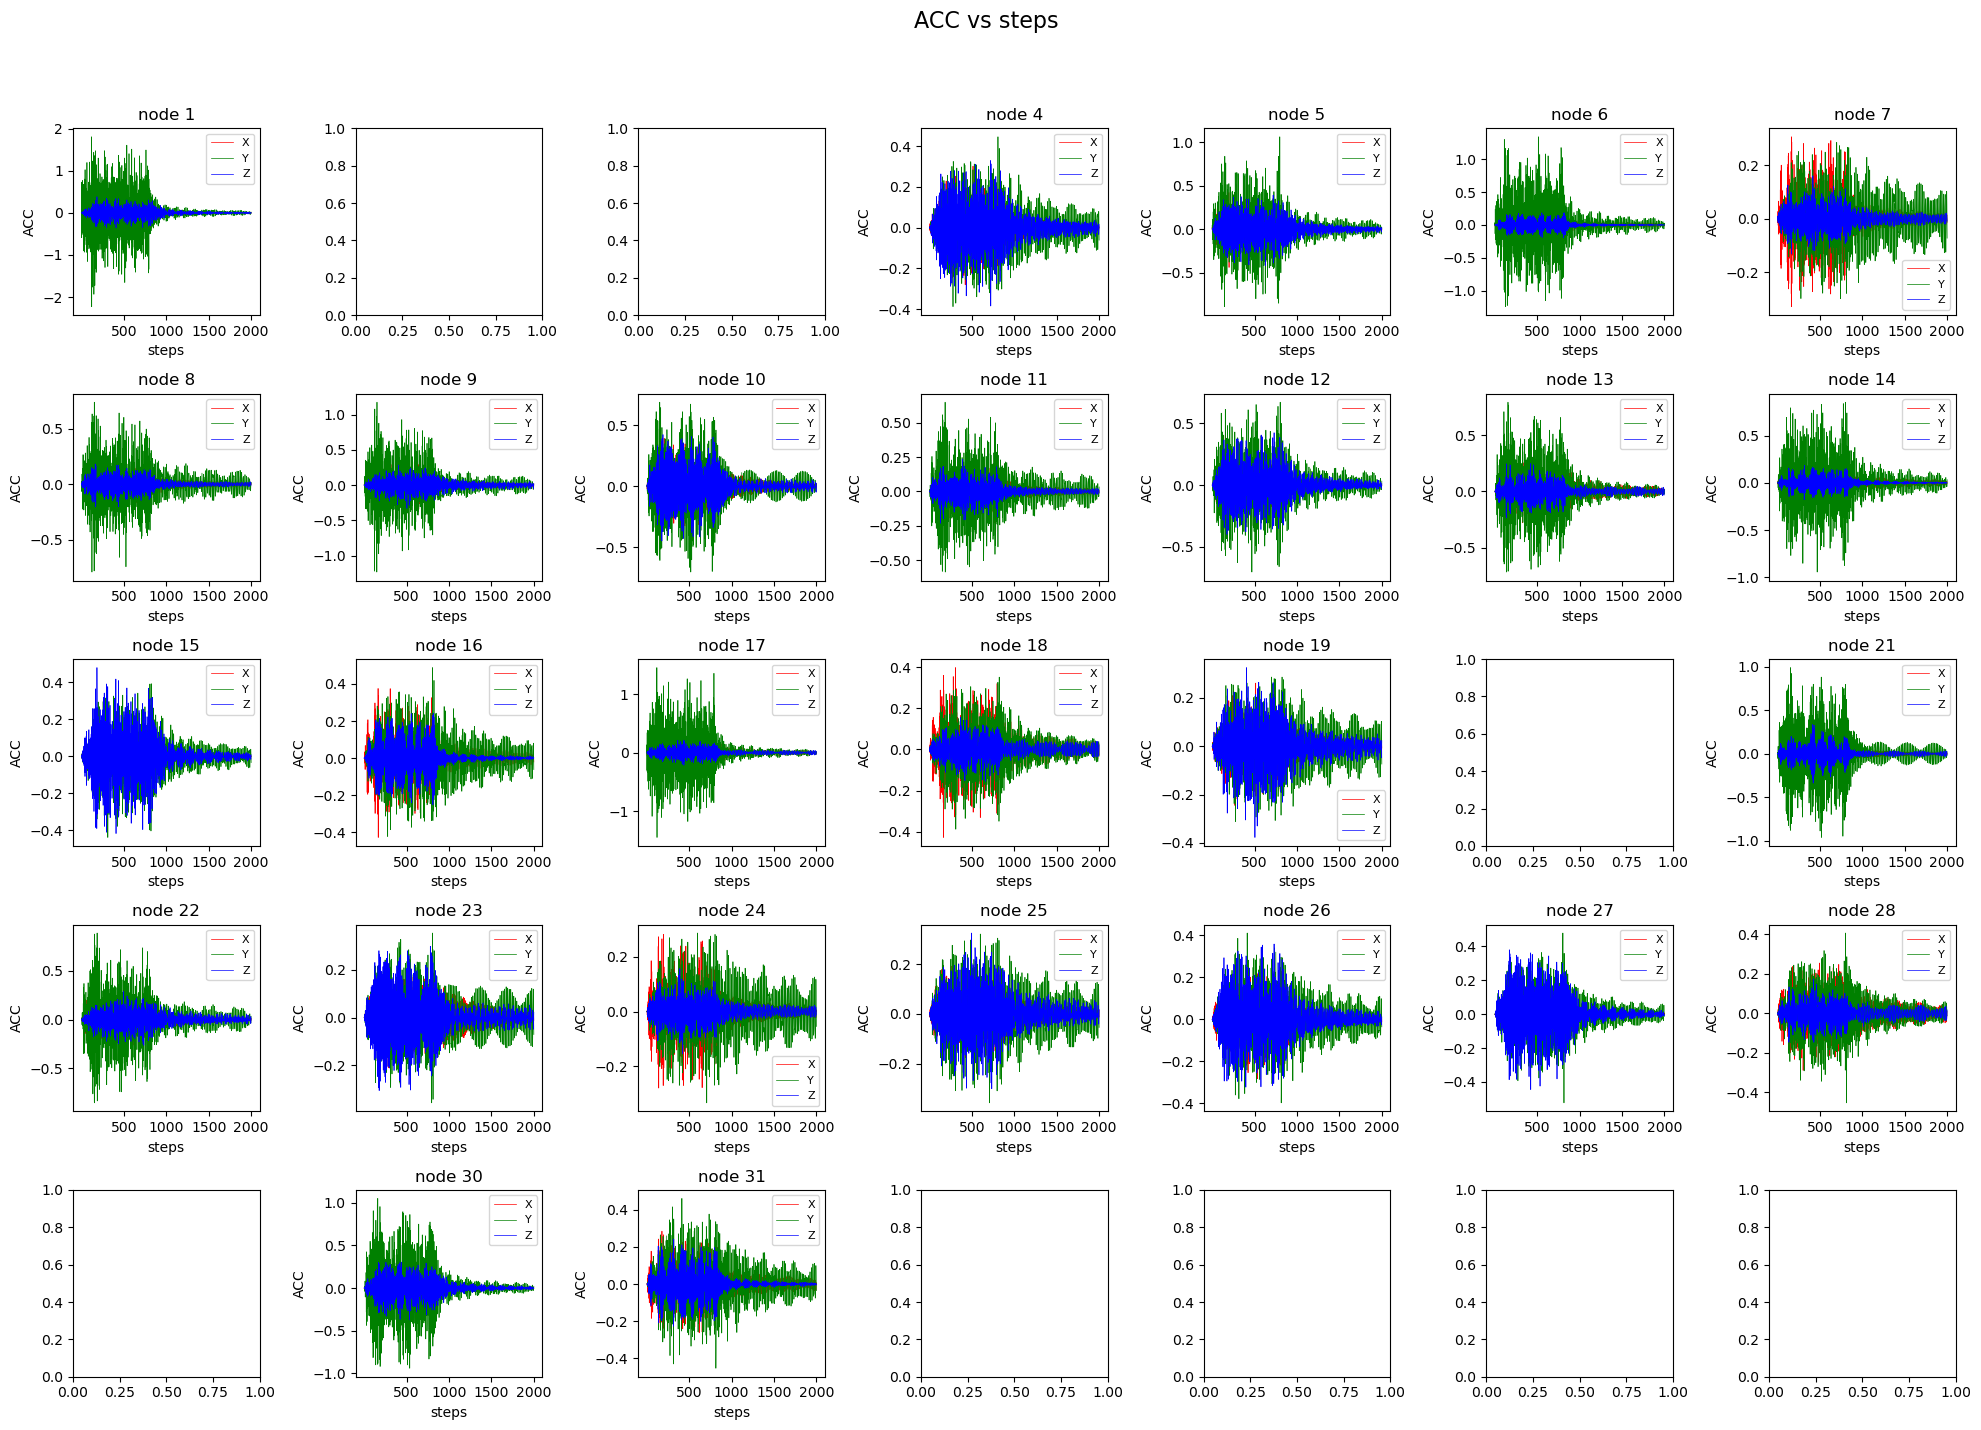

In [17]:
health_file_path = health_path + '/Health_Loadv1.csv'  

data = pd.read_csv(file_path)

num_steps = 2001  
fig, axes = plt.subplots(5, 7, figsize=(20, 15))  
fig.suptitle("ACC vs steps", fontsize=16)
nodes = data['Node ID'].unique()

for node in nodes:
    node_data = data[data['Node ID'] == node]
    increment = range(0, num_steps)
    x = node_data[' Accleration_x']
    y = node_data[' Accleration_y']
    z = node_data[' Accleration_z']
    ax = axes[(node-1) // 7, (node-1) % 7]
    ax.plot(increment, x, label='X', color='r', linewidth=0.5)
    ax.plot(increment, y, label='Y', color='g', linewidth=0.5)
    ax.plot(increment, z, label='Z', color='b', linewidth=0.5)
    
    ax.set_title(f'node {node}')
    ax.set_xticks([500, 1000, 1500, 2000])
    ax.set_xlabel('steps')
    ax.set_ylabel('ACC')
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

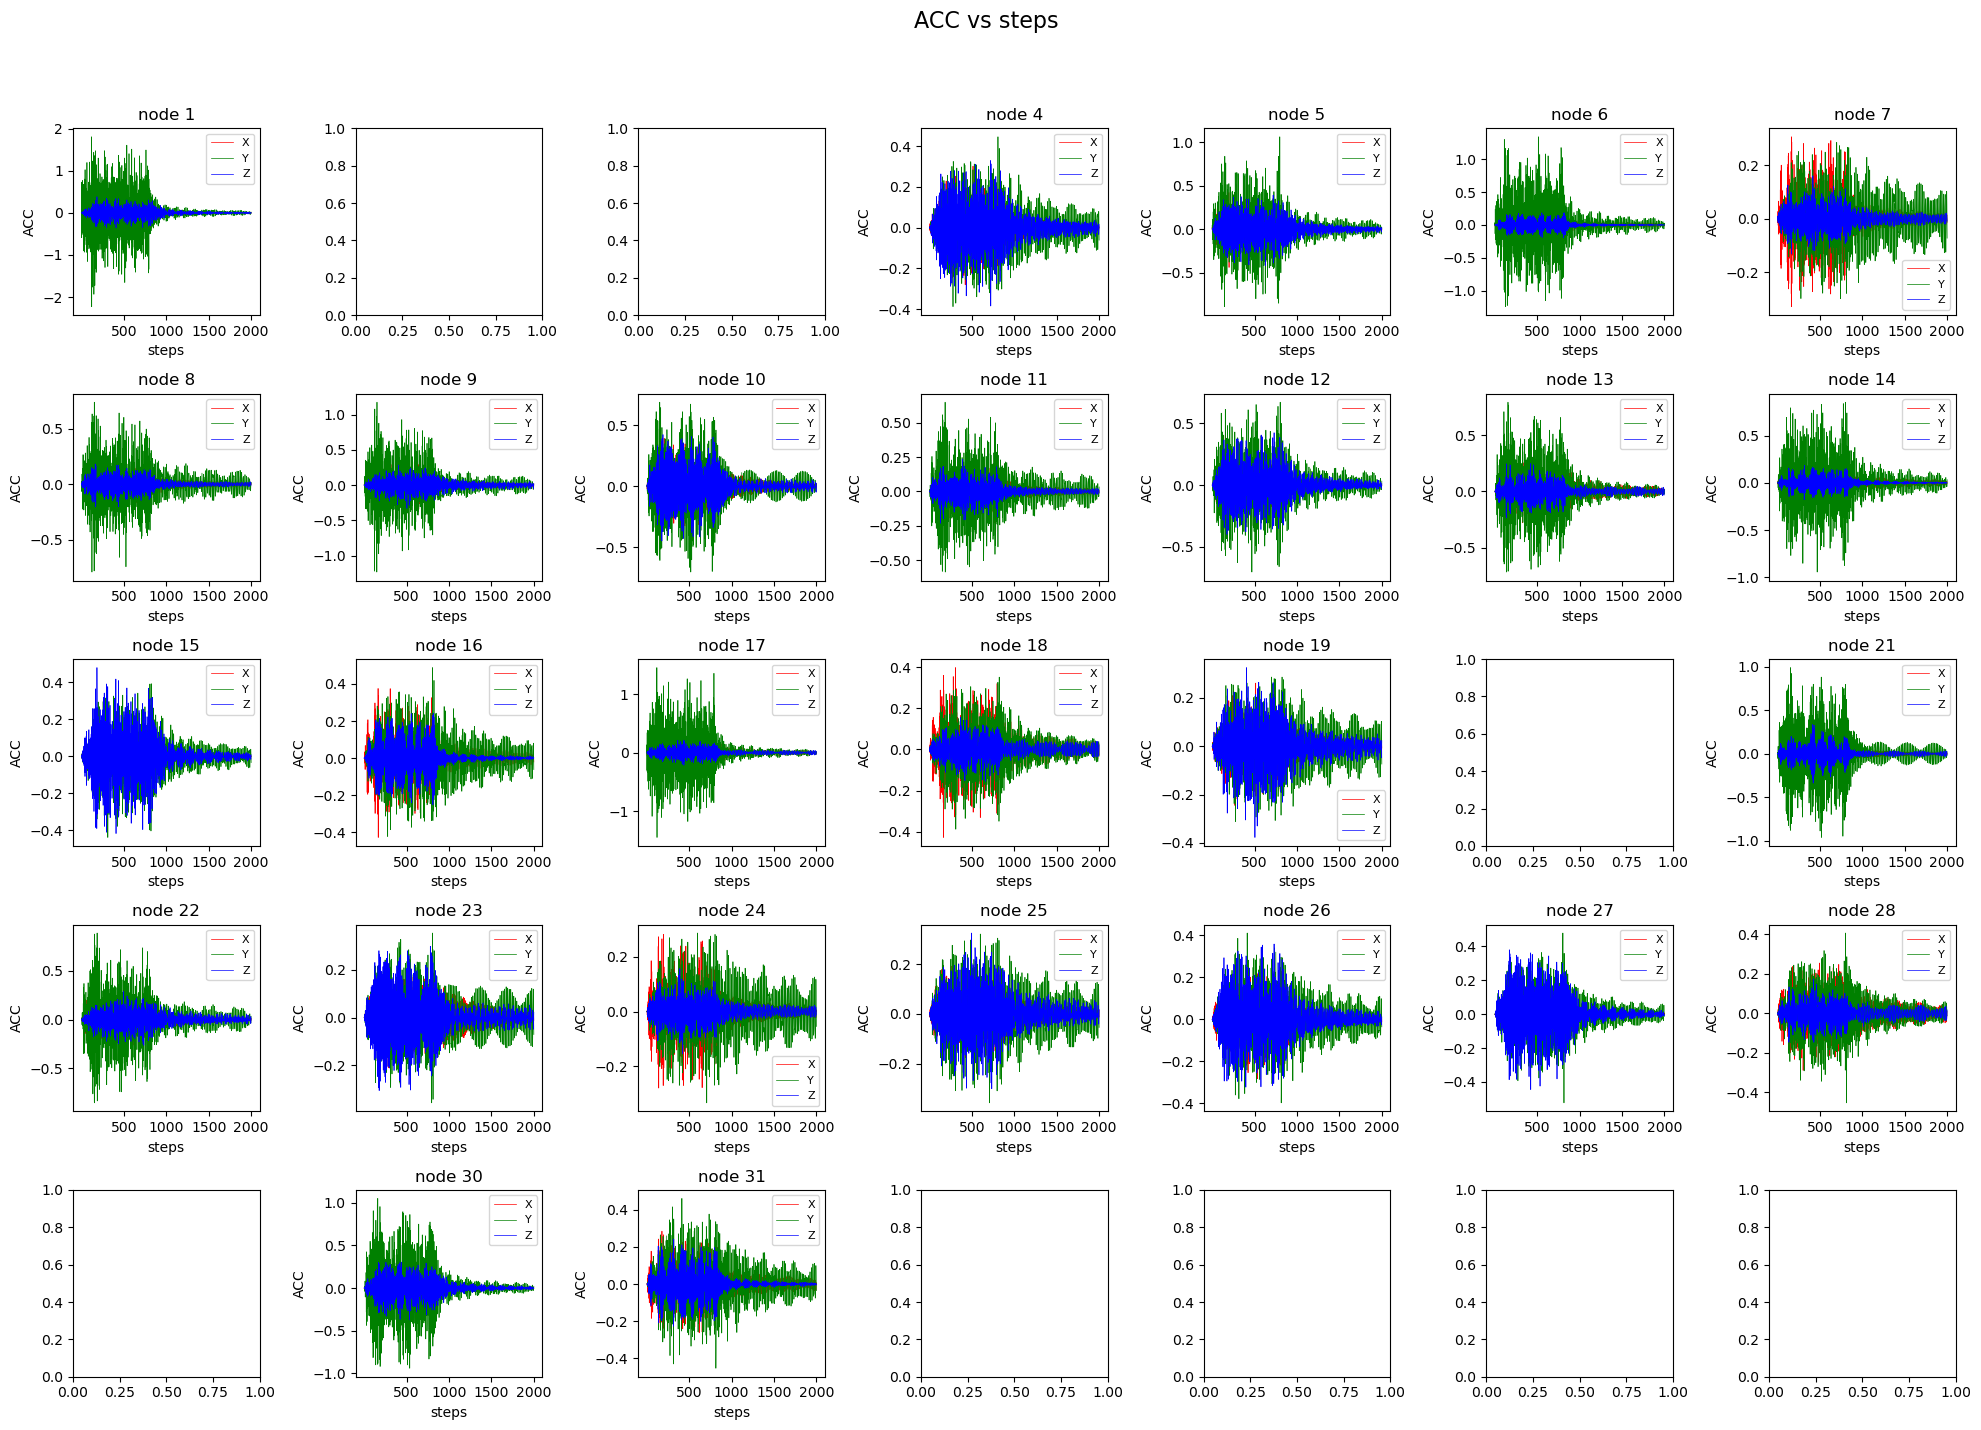

In [14]:
damage_file_path = damage_path + '/Damage_Load5.csv'  

data = pd.read_csv(file_path)

num_steps = 2001  
fig, axes = plt.subplots(5, 7, figsize=(20, 15))  
fig.suptitle("ACC vs steps", fontsize=16)
nodes = data['Node ID'].unique()

for node in nodes:
    node_data = data[data['Node ID'] == node]
    increment = range(0, num_steps)
    x = node_data[' Accleration_x']
    y = node_data[' Accleration_y']
    z = node_data[' Accleration_z']
    ax = axes[(node-1) // 7, (node-1) % 7]
    ax.plot(increment, x, label='X', color='r', linewidth=0.5)
    ax.plot(increment, y, label='Y', color='g', linewidth=0.5)
    ax.plot(increment, z, label='Z', color='b', linewidth=0.5)
    
    ax.set_title(f'node {node}')
    ax.set_xticks([500, 1000, 1500, 2000])
    ax.set_xlabel('steps')
    ax.set_ylabel('ACC')
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

In [18]:
health_file_path = health_path + '/Health_Loadv1.csv'  
damage_file_path = damage_path + '/Damage_Load1.csv'  
df = pd.read_csv(health_file_path)
unique_values_count = df['Node ID'].unique()
node_data = len(data[data['Node ID'] == 2])
print(node_data,unique_values_count)
df = pd.read_csv(health_file_path)
unique_values_count = df['Node ID'].unique()
print(unique_values_count)

0 [ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27
 28 30 31]
[ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27
 28 30 31]
